# Predict the spread of pandemic using LSTM

In [1]:
import os
import pandas as pd
import keras.models as models
import keras.layers as layers
import keras.callbacks as callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import csv


## load the file

In [2]:

def load_data(district = 'Shanghai', selector = 1) -> list:
    '''
    district: string, the form should be like 'Jinshan', 'Shanghai' or 'PudongNew'
    selector: 2 for the total nuber; 1 for Asymptomatic cases; 0 for confirmed cases.
    '''
    current_path = os.path.dirname(os.path.abspath('__file__'))
    data = pd.read_csv(current_path + '/../district_data/city_dist_unmerged_date.csv', usecols=[district])
    stats = data.values
    name = data.columns[0]
    size = stats.size
    stats_p = []
    if selector == 1:
        for j in range(size):
            if (j % 2) == 0: 
                stats_p.append(int(stats[j]))
    elif selector == 0:
        for j in range(size):
            if (j % 2) == 1: 
                stats_p.append(int(stats[j]))
    else:
        for j in range(size):
            if j % 2 == 1:
                stats_p.append(int(stats[j]))
            else:
                stats_p[-1] += int(stats[j])
    data_infecious = np.array(stats_p, dtype='uint32')
    print(data_infecious)
    return [name, data_infecious]


In [3]:
def create_dataset(dataset, look_back=1):#look_back为滑窗
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)


## Build the model

In [4]:
# Build the Model
def LSTM_train(f_look_back):
    model = models.Sequential()
    model.add(layers.LSTM(25, input_shape=(1, f_look_back)))
    model.add(layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer='adam')
    return model
  

[ 11  26  29   1  12  27  22  42  25  29  20  75  49  70  92 143 127 203
 205 164 150  76  40 142 131 145  32 349 124 110  70  20  17  20  30  16]


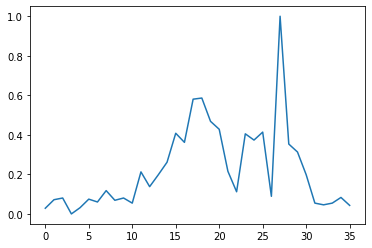

Current district: Jingan


In [5]:
load = load_data(4, 1)
dataset = load[1]
#dataset = [dataset]

dataset_sc = dataset.reshape(-1, 1) 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_sc = scaler.fit_transform(dataset_sc)
dataset_normalised =[]
for i in dataset_sc:
    dataset_normalised.append(i[0])

plt.plot(dataset_normalised) 
plt.show()

#print(dataset_sc)
print("Current district:", load[0])


## main

In [6]:
train = dataset_normalised
look_back = 7
trainX, trainY = create_dataset(train, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

model = LSTM_train(look_back)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, mode='max')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, callbacks=[reduce_lr])
predict = model.predict(trainX)



Epoch 1/100
29/29 - 1s - loss: 0.1034 - lr: 0.0010 - 1s/epoch - 35ms/step
Epoch 2/100
29/29 - 0s - loss: 0.0674 - lr: 0.0010 - 37ms/epoch - 1ms/step
Epoch 3/100
29/29 - 0s - loss: 0.0514 - lr: 0.0010 - 34ms/epoch - 1ms/step
Epoch 4/100
29/29 - 0s - loss: 0.0463 - lr: 0.0010 - 35ms/epoch - 1ms/step
Epoch 5/100
29/29 - 0s - loss: 0.0448 - lr: 0.0010 - 43ms/epoch - 1ms/step
Epoch 6/100
29/29 - 0s - loss: 0.0429 - lr: 0.0010 - 32ms/epoch - 1ms/step
Epoch 7/100
29/29 - 0s - loss: 0.0428 - lr: 0.0010 - 44ms/epoch - 2ms/step
Epoch 8/100
29/29 - 0s - loss: 0.0416 - lr: 0.0010 - 39ms/epoch - 1ms/step
Epoch 9/100
29/29 - 0s - loss: 0.0407 - lr: 0.0010 - 34ms/epoch - 1ms/step
Epoch 10/100
29/29 - 0s - loss: 0.0404 - lr: 0.0010 - 52ms/epoch - 2ms/step
Epoch 11/100
29/29 - 0s - loss: 0.0392 - lr: 0.0010 - 47ms/epoch - 2ms/step
Epoch 12/100
29/29 - 0s - loss: 0.0390 - lr: 0.0010 - 39ms/epoch - 1ms/step
Epoch 13/100
29/29 - 0s - loss: 0.0383 - lr: 0.0010 - 32ms/epoch - 1ms/step
Epoch 14/100
29/29 - 0

In [7]:
trainPredict = model.predict(trainX)

testx = [0.]*(7+look_back)
testx[0:look_back] = train[-look_back:]
testx = np.array(testx)
testPredict = [0]*7
for i in range(7):
    testxx = testx[-look_back:]
    testxx = np.reshape(testxx, (1, 1, look_back))
    testy = model.predict(testxx)
    testx[look_back+i] = testy
    testPredict[i] = testy

testPredict = np.array(testPredict)
testPredict = np.reshape(testPredict,(7,1))

1/1 [==============================] - 0s 17ms/step


In [8]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)

trainScore = math.sqrt(mean_squared_error(trainY[0,:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 61.07 RMSE


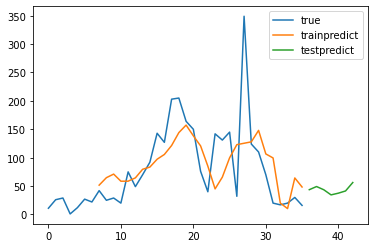

"\nprint(testPredictPlot)\n\nwrite_dataset = []\nfor i in range(trainPredictPlot.shape[0]):\n    write_dataset.append([])\n    write_dataset[-1].append([dataset[i],trainPredictPlot[i],testPredictPlot[i]])\nwith open('keras_predict.csv','w',newline='') as f:\n    file = csv.writer(f)\n    file.writerows(trainPredictPlot) \n    file.writerows(write_dataset)\n    file.writerows(testPredictPlot)\n"

In [9]:
trainPredictPlot = np.reshape(np.array([np.nan]*(len(dataset)+7)),((len(dataset)+7),1))
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.reshape(np.array([np.nan]*(len(dataset)+7)),((len(dataset)+7),1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(dataset):(len(dataset)+7), :] = testPredict

plt.plot(dataset,label='true')
plt.plot(trainPredictPlot,label='trainpredict')
plt.plot(testPredictPlot,label='testpredict')
plt.legend()
plt.show()

'''
print(testPredictPlot)

write_dataset = []
for i in range(trainPredictPlot.shape[0]):
    write_dataset.append([])
    write_dataset[-1].append([dataset[i],trainPredictPlot[i],testPredictPlot[i]])
with open('keras_predict.csv','w',newline='') as f:
    file = csv.writer(f)
    file.writerows(trainPredictPlot) 
    file.writerows(write_dataset)
    file.writerows(testPredictPlot)
'''